### Portfolio calculations are presented in a separate notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import data_loading
import solver_create_front
import moead
import new_moead
import evolutionary_operators
import evolutionary_visualizations
import utils
from pathlib import Path

In [2]:
companies = data_loading.load_all_companies_from_dir("./data/Bundle3")

In [11]:
# Using the methods from Project1 to generate the pareto fronts
ws_sol = solver_create_front.uniformly_search_weight_space(companies, 100, 400)
ws_arrays = [np.array(x[1]['x']) for x in ws_sol]
ec_sol = solver_create_front.uniformly_search_threshold_space(companies, 100, 400)
ec_arrays = [np.array(x[1]['x']) for x in ec_sol]

In [12]:
# expected returns for companies were calculated within the "uniformly_search_..." functions
ws_points = [(utils.portfolio_expected_return(companies, p)[0], utils.portfolio_risk(companies, p)) for p in ws_arrays]
ec_points = [(utils.portfolio_expected_return(companies, p)[0], utils.portfolio_risk(companies, p)) for p in ec_arrays]

In [13]:
RET_NORM_CONST = ec_points[-1][0] - ec_points[0][0]
RISK_NORM_CONST = ec_points[-1][1] - ec_points[0][1]

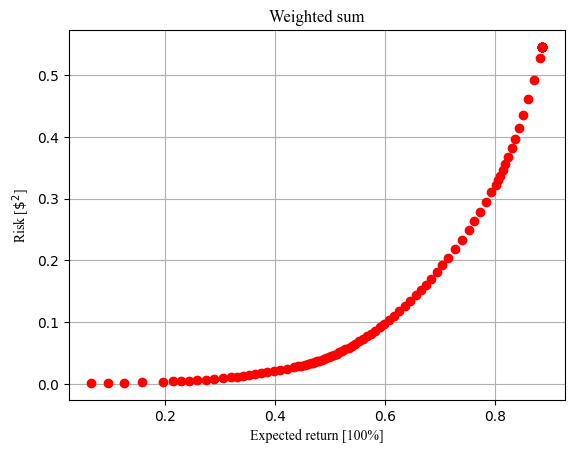

In [14]:
solver_create_front.plot_front(companies, ws_sol, title="Weighted sum")

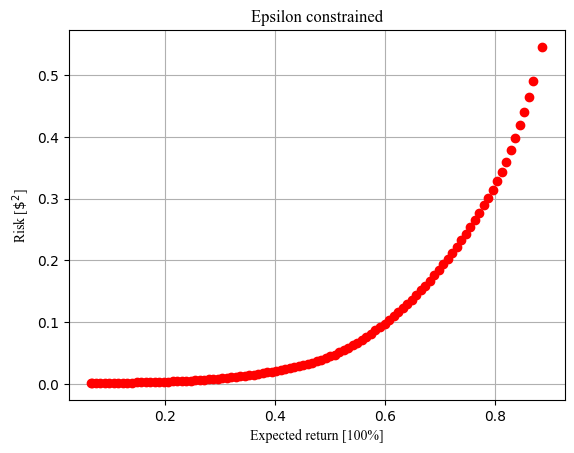

In [15]:
solver_create_front.plot_front(companies, ec_sol, title="Epsilon constrained")

In [16]:
MOEAD_PARAMETERS = {
    "n_objectives": 2,
    "fitness_function_name": "weighted_sum",
    "neighborhood_size": 5,
    "generations": 500,
    "population_size": 100,
    "crossover_distr_idx": 1,
    "crossover_mode": 0.9,
    "mutation_probability": 0.1,
}
EXPORT_PATH = "populations/exported_pop_MOEAD_bundle3.txt"

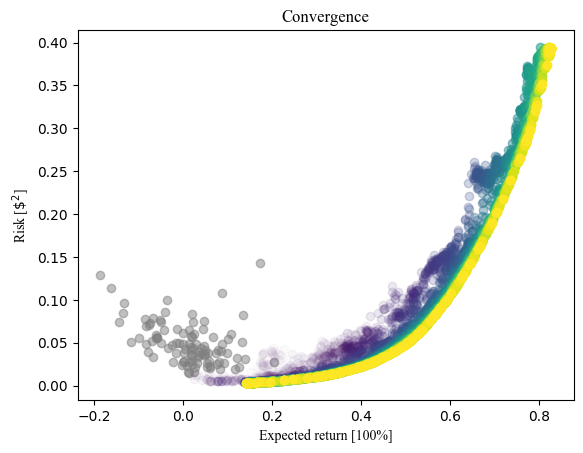

In [17]:
moead_pop, gen_number = moead.MOEAD_main_loop(companies, EXPORT_PATH, MOEAD_PARAMETERS, RET_NORM_CONST, RISK_NORM_CONST, **MOEAD_PARAMETERS)
moead.plot_population(companies, moead_pop, gen_number/MOEAD_PARAMETERS["generations"], title="Convergence", alpha=1.0, export_pdf=True)

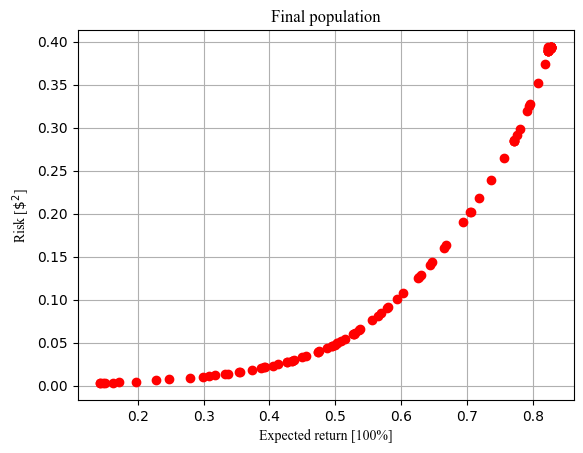

In [18]:
moead.plot_population(companies, moead_pop, gen_number/MOEAD_PARAMETERS["generations"], title="Final population", force_color="red")

## Using "soft" tournament selection

In [19]:
EXPORT_PATH = "populations/exported_pop_tournament_selection_MOEAD_bundle3.txt"
TOURNAMENT_SIZE = MOEAD_PARAMETERS["population_size"] - MOEAD_PARAMETERS["neighborhood_size"] + 1

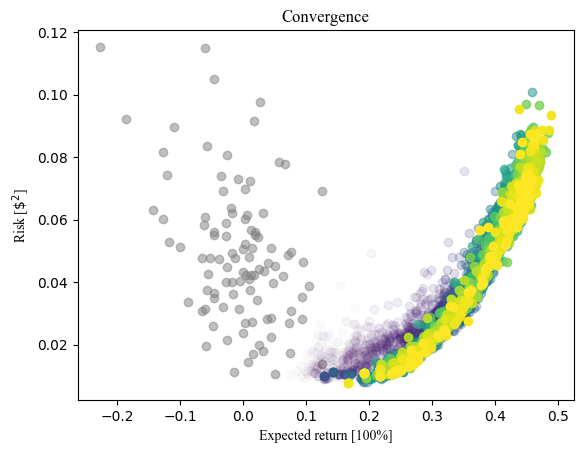

In [20]:
moead_tournament_pop, gen_number = new_moead.MOEAD_tournament_selection_main_loop(companies, EXPORT_PATH, MOEAD_PARAMETERS, TOURNAMENT_SIZE, RET_NORM_CONST, RISK_NORM_CONST, **MOEAD_PARAMETERS)
moead.plot_population(companies, moead_tournament_pop, gen_number/MOEAD_PARAMETERS["generations"], title="Convergence", alpha=1.0, export_pdf=True)

---
## Using a more exploratory recombination operator


In [21]:
EXPORT_PATH = "populations/exported_pop_exploratory_MOEAD_bundle3.txt"

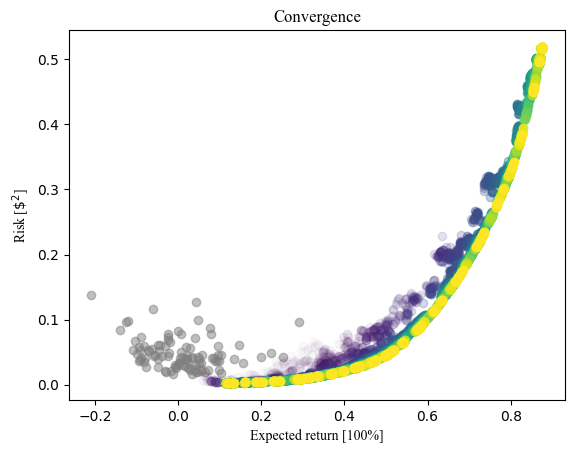

In [22]:
moead_exploratory_pop, gen_number_exploratory = new_moead.MOEAD_more_exploratory_recombination_main_loop(companies, EXPORT_PATH, MOEAD_PARAMETERS, RET_NORM_CONST, RISK_NORM_CONST, **MOEAD_PARAMETERS)
moead.plot_population(companies, moead_exploratory_pop, gen_number_exploratory/MOEAD_PARAMETERS["generations"], title="Convergence", alpha=1.0, export_pdf=True, pdf_title="exploratory_moead_pop.pdf")

In [23]:
points_moead_pop = [(utils.portfolio_expected_return(companies, w), utils.portfolio_risk(companies, w)) for w in moead_pop]
points_tournament_pop = [(utils.portfolio_expected_return(companies, w), utils.portfolio_risk(companies, w)) for w in moead_tournament_pop]
points_exploratory_pop = [(utils.portfolio_expected_return(companies, w), utils.portfolio_risk(companies, w)) for w in moead_exploratory_pop]

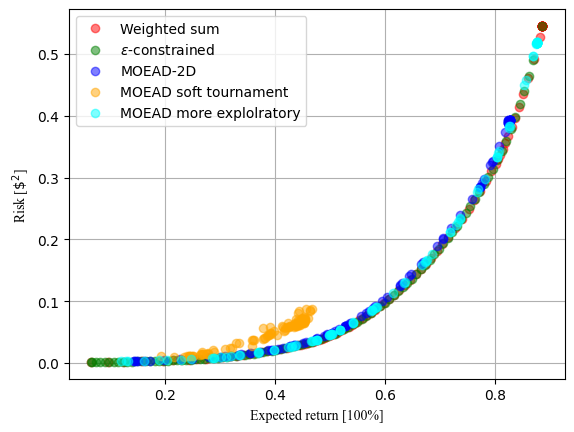

In [24]:
plt.plot(np.array(ws_points)[:, 0], np.array(ws_points)[:, 1], "o", color="red", alpha=0.5, label="Weighted sum")
plt.plot(np.array(ec_points)[:, 0], np.array(ec_points)[:, 1], "o", color="green", alpha=0.5, label="$\epsilon$-constrained")
plt.plot(np.array(points_moead_pop)[:, 0], np.array(points_moead_pop)[:, 1], "o", color="blue", alpha=0.5, label="MOEAD-2D")
plt.plot(np.array(points_tournament_pop)[:, 0], np.array(points_tournament_pop)[:, 1], "o", color="orange", alpha=0.5, label="MOEAD soft tournament")
plt.plot(np.array(points_exploratory_pop)[:, 0], np.array(points_exploratory_pop)[:, 1], "o", color="cyan", alpha=0.5, label="MOEAD more explolratory")
label_font = {'fontname': 'Times New Roman'}
plt.xlabel("Expected return [100%]", **label_font)
plt.ylabel("Risk [$ \$^2 $] ", **label_font)
plt.grid()
plt.legend()
plt.show()

----
# Evaluation

In [2]:
# need a trick to make sure that the files that have the same generation cap are plotted together
def check_gen_cap(file_path: str) -> int:
    with open(file_path) as fp:
        params_line = fp.readline().split(',')
        parameters = dict(zip(params_line[::2], params_line[1::2]))
        return int(parameters["generations"])


def plot_igd_with_gen_cap_from_dir(front_points: np.ndarray[np.float32], dir_path: str, target_gen_cap: int, glob_pattern: str) -> None:
    files = Path(dir_path).glob(glob_pattern)
    for file in files:
        gen_cap = check_gen_cap(file)
        if gen_cap != target_gen_cap:
            continue
        parameters, generations, points = evolutionary_operators.load_population_points(file)
        evolutionary_visualizations.plot_convergence_inverted_gen_distance(front_points, parameters, generations, points, show=False)
    plt.show()

## Using "soft" tournament selection

In [4]:
experiment_files = Path("./populations/").glob("EXPERIMENT_2024-04-05*.txt")
ec1_front_points = data_loading.load_saved_front("./saved_fronts/ec_front1.txt")

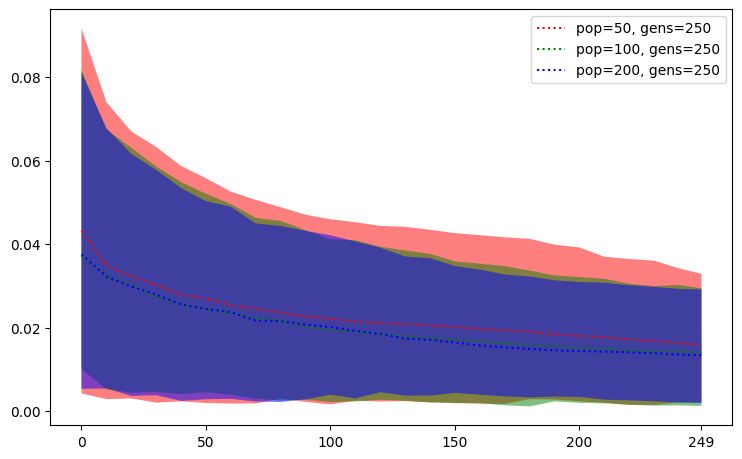

In [5]:
plot_igd_with_gen_cap_from_dir(ec1_front_points, "./populations/", 250, "EXPERIMENT_2024-04-05*.txt")

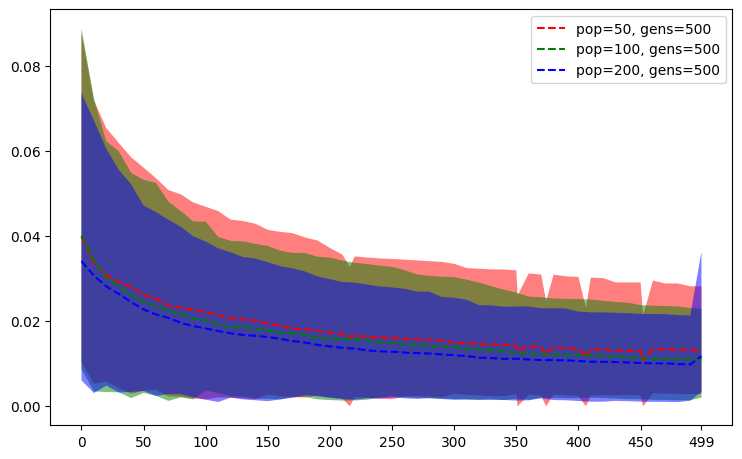

In [6]:
plot_igd_with_gen_cap_from_dir(ec1_front_points, "./populations/", 500, "EXPERIMENT_2024-04-05*.txt")

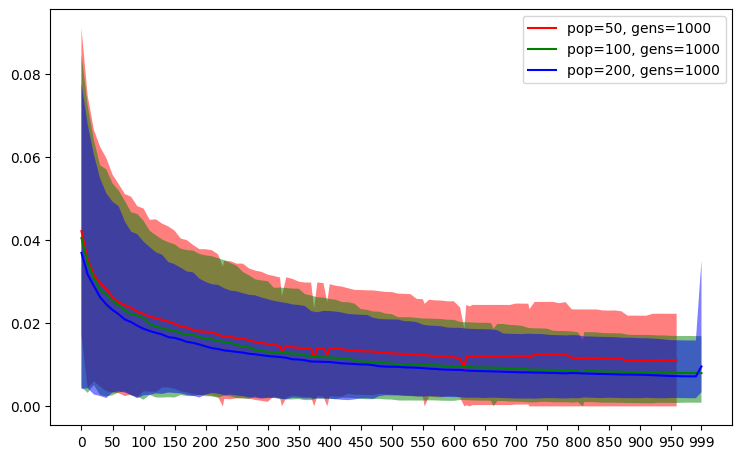

In [5]:
plot_igd_with_gen_cap_from_dir(ec1_front_points, "./populations/", 1000, "EXPERIMENT_2024-04-05*.txt")

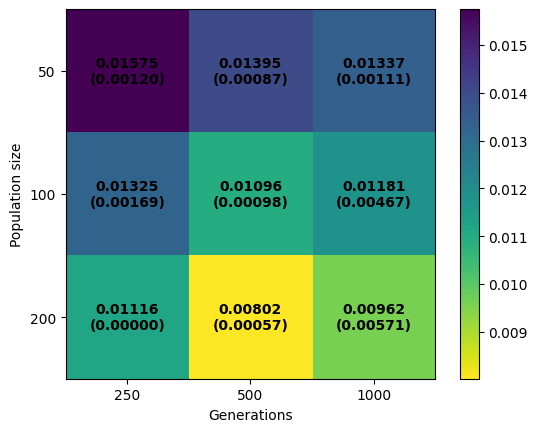

In [3]:
evolutionary_visualizations.igd_heatmap_from_file("igd_points_soft_tournament.txt")

## More explorative crossover

In [16]:
experiment_files = Path("./populations/").glob("EXPERIMENT_2024-04-03*.txt")
ec1_front_points = data_loading.load_saved_front("./saved_fronts/ec_front1.txt")

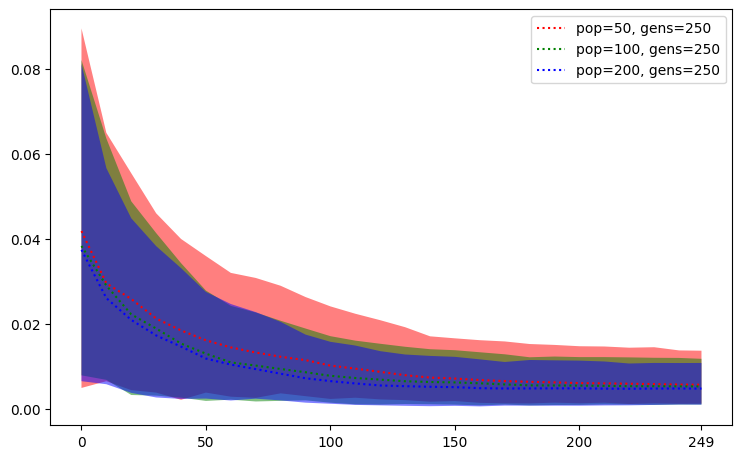

In [17]:
plot_igd_with_gen_cap_from_dir(ec1_front_points, "./populations/", 250, "EXPERIMENT_2024-04-03*.txt")
# plot_igd_with_gen_cap_from_dir(ec1_front_points, "./populations/", 250, "EXPERIMENT_2024-04-03-15-16-25.txt")

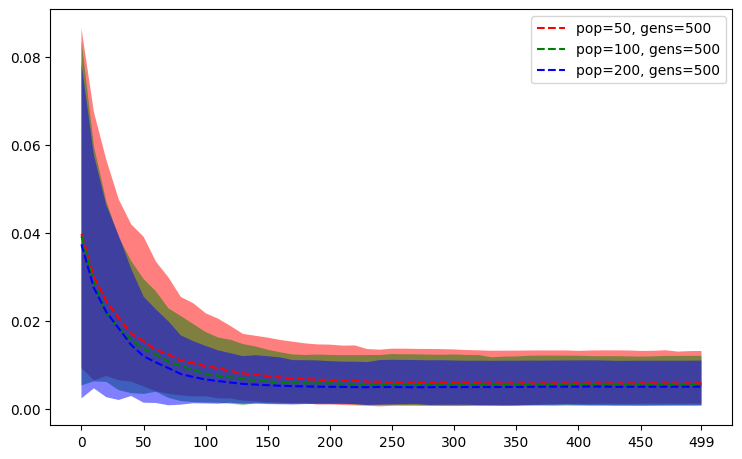

In [18]:
plot_igd_with_gen_cap_from_dir(ec1_front_points, "./populations/", 500, "EXPERIMENT_2024-04-03*.txt")

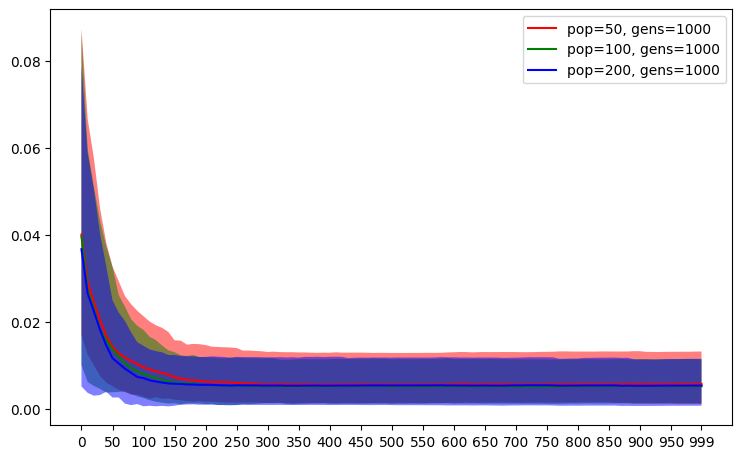

In [19]:
plot_igd_with_gen_cap_from_dir(ec1_front_points, "./populations/", 1000, "EXPERIMENT_2024-04-03*.txt")

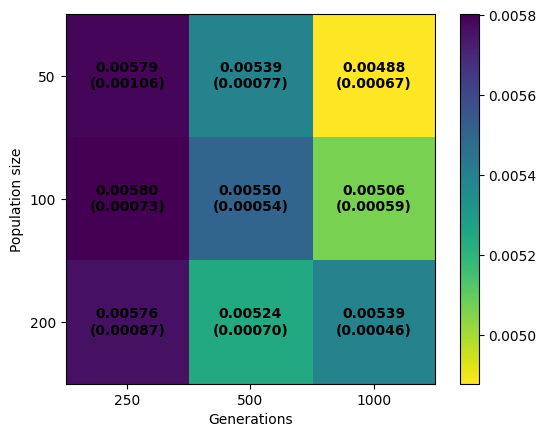

In [2]:
evolutionary_visualizations.igd_heatmap_from_file("igd_points_more_random.txt")